In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle

In [3]:
from scipy.signal import savgol_filter

In [4]:
from resonator_tools.circuit import notch_port
from resonator_tools import circlefit

In [ ]:
from int_to_roman import int_to_roman

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
matplotlib.rc("font", **{"size":11})
matplotlib.rcParams['axes.autolimit_mode'] = 'round_numbers'
matplotlib.rcParams['axes.xmargin'] = 0
matplotlib.rcParams['axes.ymargin'] = 0

In [9]:
chip_name = 'Dmitriev_Xmon-in-Nb-res'

## Loading

In [39]:
with open("./data/2017-08-04/%s_resonators_on_power.pkl"%chip_name, "rb") as f:
    scan_areas, powers, power_scans = pickle.load(f)

In [40]:
scan_areas.sort()

In [41]:
scan_areas

[(7589266426.642664, 7639266426.642664),
 (7668384338.4338436, 7718384338.4338436),
 (7750292529.2529249, 7800292529.2529249),
 (7817169216.9216919, 7867169216.9216919),
 (7903802880.2880287, 7953802880.2880287)]

In [42]:
power = 0
scan = scan_areas[0]

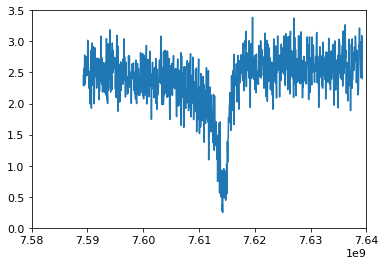

In [43]:
freqs, S21s = power_scans[scan][power][0], power_scans[scan][power][1]
plt.plot(freqs, abs(S21s))

## Fitting

In [44]:
resonators_data = []
sim_S21s = []
for idx, scan in enumerate(scan_areas[:]):
    print("\rScan:",str(idx+1)+"/"+str(len(scan_areas)), end="")
    Qls = []
    Qis = []
    Qis_err = []
    Qes = []
    frs = []
    for power in range(len(powers)):
        freqs, S21s = power_scans[scan][power][0], power_scans[scan][power][1]
        S21s_filtered = (savgol_filter(real(S21s), 41, 2) + 1j*savgol_filter(imag(S21s), 41, 2))
        np = notch_port(freqs, S21s_filtered)
        np.autofit()
        if 10e2<np.fitresults["Qi_dia_corr"]<1e6 or len(Qls)==0:
            Qls.append(np.fitresults["Ql"])
            Qes.append(np.fitresults["Qc_dia_corr"])
            Qis.append(np.fitresults["Qi_dia_corr"])
            Qis_err.append(np.fitresults["Qi_dia_corr_err"])
        else:
            Qls.append(Qls[-1])
            Qes.append(Qes[-1])
            Qis.append(Qis[-1])
            Qis_err.append(Qis_err[-1])
            frs.append(frs[-1])
            continue
        if abs(np.fitresults["fr"]) <1e10 or len(frs)==0:
            frs.append(np.fitresults["fr"])
        else:
            frs.append(frs[-1])
    resonators_data.append((Qls, Qis, Qes, frs))
    sim_S21s.append(np.z_data_sim)

Scan: 5/5

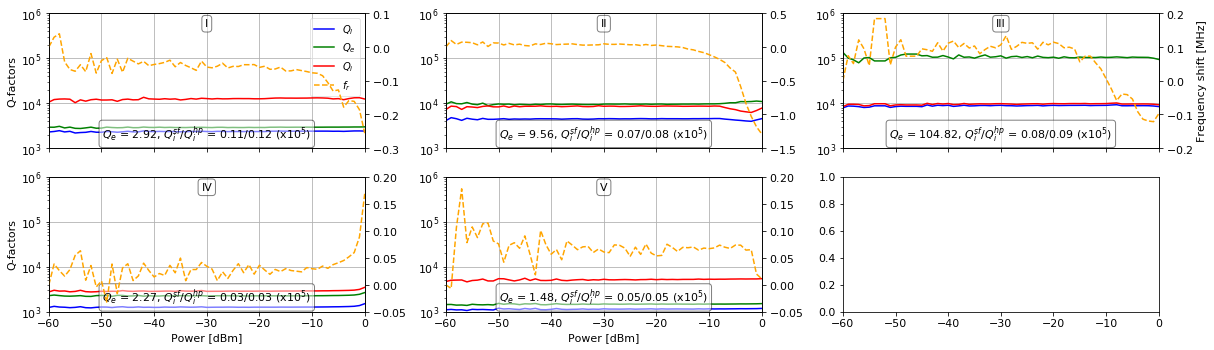

In [45]:
# matplotlib.rc("font", **{"size":11})
rows = 2
cols = 3
fig, axes = plt.subplots(rows, cols, figsize = (17, 5), sharex = True)
greek_nums = ["I", "II", "III", "IV", "V"]
# greek_nums = list(map(int_to_roman, range(1, 25)))

data_to_drop = []
resonators_data_clean = resonators_data.copy()

offset_coeff = 0
for idx, ax in list(enumerate(flatten(axes)))[:-1]:
    
    if idx in data_to_drop:
        ax.set_ylim(1e3, 1e6)
        ax.set_xlim(-60, 0)
        ax.set_yscale("log")
        ax.text(mean(ax.get_xlim()), ax.get_ylim()[1]/2, greek_nums[idx], bbox=props, horizontalalignment="center")
        if idx in data_to_drop:
            del resonators_data_clean[idx-offset_coeff]
            ax.text(mean(ax.get_xlim()), ax.get_ylim()[0]*1.7, "Bad data/bad resonance.",
                bbox=props, horizontalalignment="center")
        else:
            ax.text(mean(ax.get_xlim()), ax.get_ylim()[0]*1.7, "Wasn't fitted.",
                bbox=props, horizontalalignment="center")
        if (idx)>=(rows-1)*cols:
            ax.set_xlabel("Power [dBm]")
        ax2 = ax.twinx()
        if not (idx-(cols-1))%cols:
            ax2.set_ylabel("Frequency [kHz]")
        offset_coeff += 1

        continue
        
    Qls, Qis, Qes, frs = resonators_data_clean[idx-offset_coeff]
    lns = ax.plot(powers, Qls, label = "$Q_l$", color="b")
    lns += ax.plot(powers, Qes, label = "$Q_e$", color="g")
    lns += ax.plot(powers, Qis, label = "$Q_i$", color="r")

#     spines(ax)

    ax.set_yscale("log")
    if not (idx)%cols:
        ax.set_ylabel("Q-factors")
    ax.set_ylim(1e3, 1e6)
    ax.set_xlim(-60,0)
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    ax.text(mean(ax.get_xlim()), ax.get_ylim()[1]/2, greek_nums[idx], bbox=props, horizontalalignment="center")
    ax.text(mean(ax.get_xlim()), ax.get_ylim()[0]*1.7, "$Q_e$ = %.2f"%(median(Qes)/1e3)+
            ", $Q_i^{sf}/Q_i^{hp}$ = %.2f/%.2f"%(Qis[0]/1e5, Qis[-1]/1e5)+" (x10$^\mathregular{5}$)", 
            bbox=props, horizontalalignment="center")
    
    if (idx)>=(rows-1)*cols:
        ax.set_xlabel("Power [dBm]")
    ax.grid()
    
    ax2 = ax.twinx()
#     spines(ax2)

    lns += ax2.plot(powers, (array(frs)-frs[0])/1e6, "--", label = '$f_r$', color="orange")
    y_formatter = matplotlib.ticker.ScalarFormatter(useMathText=True, useOffset=True)
    ax2.yaxis.set_major_formatter(y_formatter)
    if not (idx-(cols-1))%cols:
        ax2.set_ylabel("Frequency shift [MHz]")
    ax2.set_xlim(-60,0)

#     ax2.yaxis.get_offset_text().set_y(1.5)

axes[0][0].legend(lns, [ln.get_label() for ln in lns], loc=1, framealpha=0.5, fancybox=True, fontsize=10)
    
plt.tight_layout()
file = "./data/2017-08-04/q-factors-and-freqs_%s.pdf"%chip_name
plt.savefig(file, bbox_inches="tight")

## Individual fit

In [49]:
power = 0
scan = scan_areas[1]
freqs, S21s = power_scans[scan][power][0], power_scans[scan][power][1]
S21s_filtered = (savgol_filter(real(S21s), 21, 2) + 1j*savgol_filter(imag(S21s), 21, 2))
np = notch_port(freqs, S21s)
np.autofit()

In [50]:
np.fitresults

{'Qc_dia_corr': 199360.3780870355,
 'Qi_dia_corr': -322881.69234773325,
 'Qi_dia_corr_err': 3234206.7289023292,
 'Qi_no_corr': -319136.27708853665,
 'Qi_no_corr_err': 3159846.4612048864,
 'Ql': 521123.14906211512,
 'Ql_err': 10257502.963031264,
 'absQc': 197926.13628653306,
 'absQc_err': 366820.24479364726,
 'chi_square': 2.1056851141752237,
 'fr': 7741479455.4275112,
 'fr_err': 46179.566133931155,
 'phi0': 0.12002382771542167,
 'phi0_err': 2.7278896742855459,
 'theta0': -2.9867470779030683}

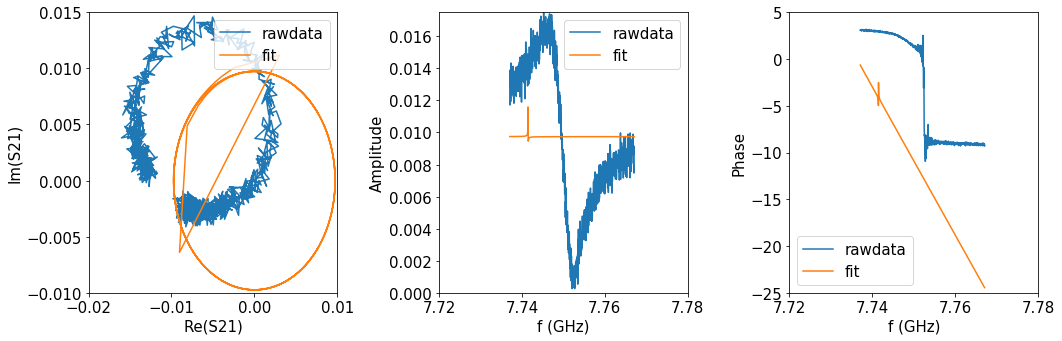

In [51]:
matplotlib.rc("font", **{"size":15}) 
np.plotall()

In [22]:
np.get_single_photon_limit()

-137.35911774017285

In [84]:
cf = circlefit.circlefit()

In [85]:
A1, A2, A3, A4, fr, Ql = cf._fit_skewed_lorentzian(freqs, S21s)

In [86]:
def lor(x):
    return A1+A2*(x-fr)+(A3+A4*(x-fr))/(1.+4.*Ql**2*((x-fr)/fr)**2)

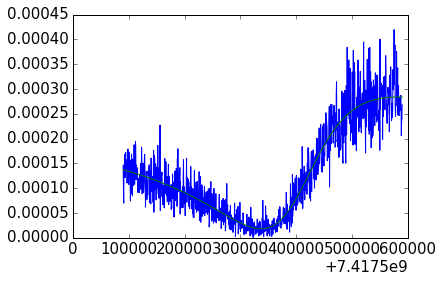

In [87]:
plt.plot(freqs, abs(S21s)**2)
plt.plot(freqs, lor(freqs))

In [88]:
Ql

31957.730937714925

In [65]:
cf._phase_fit(freqs, S21s, -2.29, 1000, 5.84e9)

array([ -4.19739983e+00,   1.01500992e+03,   5.62964717e+12])

In [ ]:
cf._fit_circle()

In [43]:
with open("/home/gleb/Документы/Science/Reverse engineering of XMons/Resonators/Resonators Nb/Res_Nb_MISIS_5.pkl", "rb") as f:
    data = pickle.load(f)

/home/gleb/.ENV/lib/python3.4/site-packages/resonator_tools-0.1-py3.4.egg/resonator_tools/circuit.py:195: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if f_data!=None:
/home/gleb/.ENV/lib/python3.4/site-packages/resonator_tools-0.1-py3.4.egg/resonator_tools/circuit.py:199: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if z_data_raw!=None:
/home/gleb/.ENV/lib/python3.4/site-packages/resonator_tools-0.1-py3.4.egg/resonator_tools/circuit.py:294: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if cov!=None:


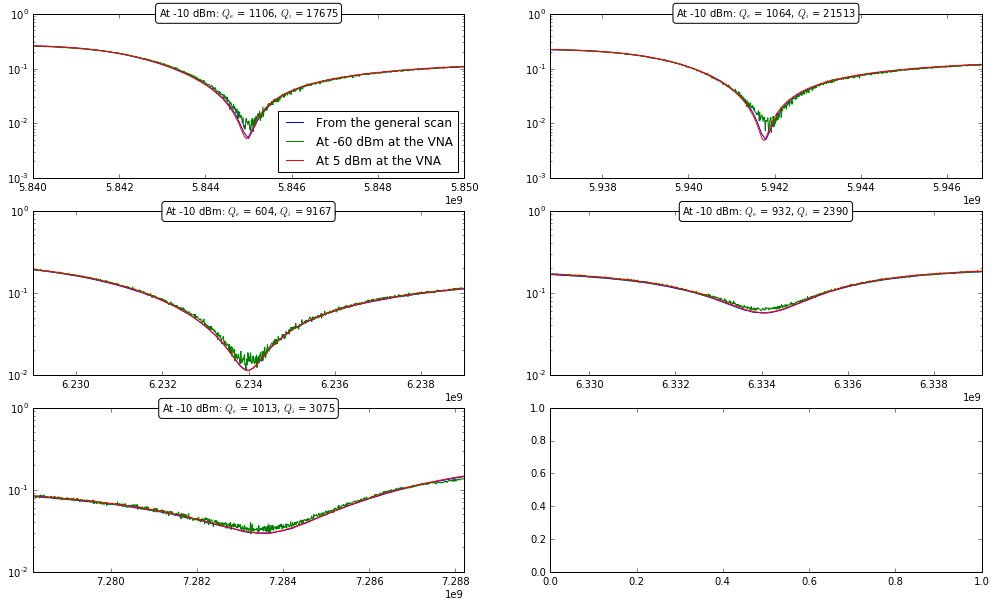

In [109]:
fig, axes = plt.subplots(3,2, figsize = (17, 10))
axes = list(flatten(axes))
for scan_area in range(0,5):
    mask = logical_and(data[0]<(scan_areas[scan_area][1]+0.05e9), (scan_areas[scan_area][0]-0.05e9)<data[0])
    axes[scan_area].plot(data[0][mask], abs(data[1][mask]), label="From the general scan")
    freqs, S21s = power_scans[scan_areas[scan_area]][0][0], power_scans[scan_areas[scan_area]][0][1]
    axes[scan_area].plot(freqs, abs(S21s), label="At %d dBm at the VNA"%(powers[0]))
    freqs, S21s = power_scans[scan_areas[scan_area]][-1][0], power_scans[scan_areas[scan_area]][-1][1]
    axes[scan_area].plot(freqs, abs(S21s), label="At %d dBm at the VNA"%(powers[-1]))
    
    axes[scan_area].set_yscale("log")
    axes[scan_area].set_xlim(scan_areas[scan_area])
    
    np = notch_port(data[0][mask], (data[1][mask]))
    np.autofit()
    Qe = np.fitresults["Qc_dia_corr"]
    Qi = np.fitresults["Qi_dia_corr"]
    axes[scan_area].text(mean(axes[scan_area].get_xlim()), axes[scan_area].get_ylim()[1]*0.9, "At -10 dBm: $Q_e$ = %i"%Qe+
        ", $Q_i$ = %i"%Qi, bbox=props, horizontalalignment="center")
    
axes[0].legend(loc=4)
plt.savefig("/home/gleb/Документы/Science/Reverse engineering of XMons/Resonators/Pictures/q-factors-and-freqs_res_nb_misis_5.pdf",
            bbox_inches="tight")

In [83]:
np = notch_port(data[0][mask], (data[1][mask]))
np.autofit()

/home/gleb/.ENV/lib/python3.4/site-packages/resonator_tools-0.1-py3.4.egg/resonator_tools/circuit.py:195: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if f_data!=None:
/home/gleb/.ENV/lib/python3.4/site-packages/resonator_tools-0.1-py3.4.egg/resonator_tools/circuit.py:199: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if z_data_raw!=None:
/home/gleb/.ENV/lib/python3.4/site-packages/resonator_tools-0.1-py3.4.egg/resonator_tools/circuit.py:294: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if cov!=None:


In [84]:
np.fitresults

{'Qc_dia_corr': 1013.9766998616541,
 'Qi_dia_corr': 3075.2143081035333,
 'Qi_dia_corr_err': 252.22563463911601,
 'Qi_no_corr': -7619.4121679366963,
 'Qi_no_corr_err': 1187.038616231745,
 'Ql': 762.54585550646573,
 'Ql_err': 11.967935902904207,
 'absQc': 693.17349881799498,
 'absQc_err': 2.7018990033870032,
 'chi_square': 0.001137505291919671,
 'fr': 7287751586.2425547,
 'fr_err': 83643.288773597218,
 'phi0': -0.81808682950078049,
 'phi0_err': 0.016746262430061019,
 'theta0': 2.3235058240890125}

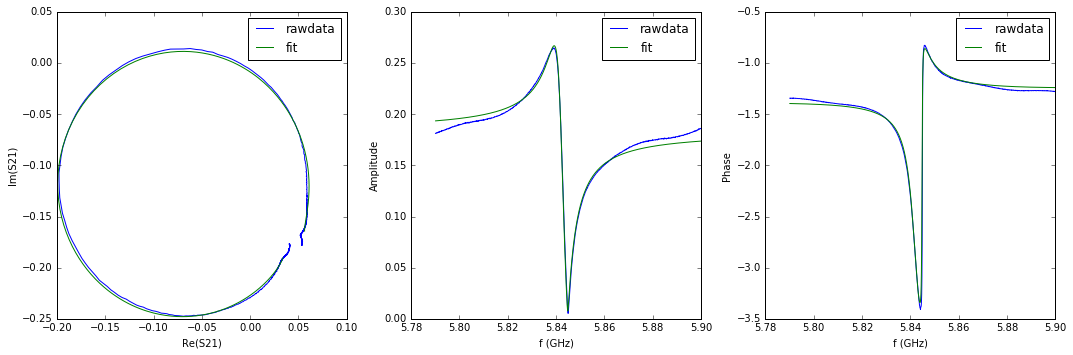

In [65]:
np.plotaall()

In [ ]:
cf._phase_fit()